# neural encoding models

This notebook runs neural encoding models using linear methods (reduced rank regression) and deep learning methods (one-layer CNN with max pooling, multilayer CNN). Originally, the models mapped texture data to the neural responses of mice, but they can be adapted for any dataset.

### Notebook Contains

**Models**
* Reduced Rank Regression (RRR)
* One-layer CNN w/ max pooling (SimplePoolCNN)
* Multi-layer CNN (MultilayerCNN)

**Statistics**
* Pearson's Correlations for RRR and SimplePoolCNN
* Logistic Regression Accuracy for one-vs-rest texture classification on predictions from SimplePoolCNN

# load data

### import libraries

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from Farah.neural_utils import neural_data_preprocess, denoise_spks, stim_preprocess
import os
import random

from dev.encoding.reduced_rank_regression import rrr_by_neuron
from dev.visualize_neuron.neuron_position import retinotopy

from sklearn.decomposition import PCA

from statistics import mean
import matplotlib.pyplot as plt

### load neural data

We load sample neural data of 100 neurons sampled at 13860 timepoints.

In [2]:
import numpy as np
import os

save_result = {}

# Load neural data
NC = 32
file_path = "../receptive_fields/sample_data/sample_neural_data.npz"
spks, istim, xpos, ypos = neural_data_preprocess(file_path)
Lyd, Lxd = 18, 48
Z = stim_preprocess(istim, Lyd, Lxd, is_old=True)

load data done!
spks shape:  (100, 13860)
istim shape:  (13860,)
load stimuli done! shape:  (13860, 864)


# RRR

We run reduced rank regression for our first neural encoding model.

Running RRR for rank 110
On split 0
On split 1
On split 2
On split 3
On split 4
On split 5
Mean: 0.4316667053181485


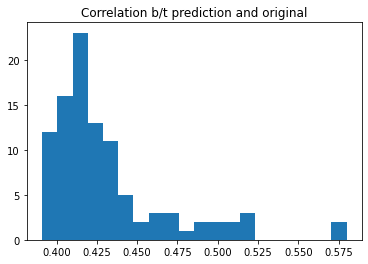

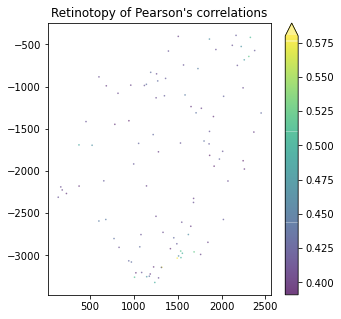

In [3]:
# Run RRR
bins=20

# Get PCs. Change to reduce dimensionality of the data, good for large datasets.
pca = PCA()

vt = pca.fit(spks.T).components_
US = (spks.T - pca.mean_) @ vt.T
spks_hat = (US @ vt) + pca.mean_
pca_mean = pca.mean_

# Run RRR 
total_pearson_rrr_re_pc, total_pearson_rrr_orig_pc, y_pred_rrr_pc, y_test_rrr_pc, rrr_test_idx_pc = rrr_by_neuron(Z, US, vt, pca_mean,
                                                                                    spks, lam=1, rank=110,
                                                                                    splits=6)
# Visualize
avg_acc_orig_rrr_pc = list(map(lambda x: mean(total_pearson_rrr_orig_pc[x]), total_pearson_rrr_orig_pc))
plt.figure()
plt.hist(avg_acc_orig_rrr_pc, bins=bins)
plt.title("Correlation b/t prediction and original")
print("Mean:", mean(avg_acc_orig_rrr_pc))

save_result["pearson_rrr"] = mean(avg_acc_orig_rrr_pc)

retinotopy(xpos, ypos, avg_acc_orig_rrr_pc)

# CNN

We load a 1 layer CNN. If you'd like the multilayer CNN, just swap the commented-out line. Feel free to change the hyperparameters (e.g. epoch, learning rate) to be the most suited to your dataset.

We train the CNN with KFold cross-validation in order to maximize the size of our dataset.

### set directories and import libraries

In [7]:
# CHANGE THESE TO SAVE LOGGING AND MODEL

RUN_NAME = "test_1" # name of run for logging
OUTPUT_PATH = "save_test_1" # where to save model

In [8]:
from sklearn.model_selection import KFold

from dev.encoding.CNN import SimpleCNNPool
from dev.encoding.CNN import MultiCNN

from torch.utils.data import TensorDataset, DataLoader
import torch
from collections import defaultdict
import scipy
from scipy.stats import pearsonr
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl

### train CNN with kfold

Swap the model line to change your model.

#### choose split number for kfold

In [9]:
SPLITS=4

#### train! 

In [11]:
kf = KFold(n_splits=SPLITS, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device ", device)

collect_all_pearsons = []

for idx, (train_index, test_index) in enumerate(kf.split(Z)):
    
    print("On split ", idx)
    
    # Prepare data
    Xtr, Xte = Z[train_index], Z[test_index]
    ytr, yte = spks.T[train_index], spks.T[test_index]
    X_train = torch.from_numpy(Xtr).float().view(-1,18,48)
    X_test = torch.from_numpy(Xte).float().view(-1,18,48)
    y_train = torch.from_numpy(ytr).float()
    y_test = torch.from_numpy(yte).float()

    NT, NN = ytr.shape

    print("Training data shape (X, Y):", X_train.shape, y_train.shape)
    print("Test data shape (X, Y):", X_test.shape, y_test.shape)

    # Prepare naming and logging
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/{}-kf-{}'.format(RUN_NAME, idx))    
    
    # Train! Tweak hyperparameters as necessary.
    trainer = pl.Trainer(
                         gpus=1, 
                         max_epochs=100, 
                         val_check_interval=1.0, 
                         test_percent_check=1.0, 
                         logger=tb_logger,
                         )
    
    ## PICK AND CONFIGURE MODEL

    ### Uncomment model below for simple CNN
    model = SimpleCNNPool(X_train, y_train, 
                          X_test, y_test,
                          learning_rate=6e-5, # 10e-7 smooth training curve but slow
                          c_out=45,
                          k=4,
                          n_neurons=NN,
                          weight_decay=1e-04,
                          size_pool=4,
                          batch_size=64,)

    ### Uncomment model for MultiCNN
    #     model = MultiCNN(NN, X_train, y_train,
    #                      X_test, y_test, 
    #                      learning_rate=6e-5,
    #                      weight_decay=1e-04,
    #                      batch_size=64,
    #                      k = 7, c_in = 1, c_out = 32, size_pool = 2)

    
    # Train!
    trainer.fit(model)
    
    # See model accuracy
    model.eval()
    batch_size=64
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False, num_workers=96)

    y_pred_matrix = []
    y_test_matrix = []
    for batch in test_loader:
        x_te, y_te = batch
        y_pred = model(x_te)
        y_pred_matrix.append(y_pred.detach().cpu())
        y_test_matrix.append(y_te)
    
    y_pred_matrix = torch.cat(y_pred_matrix)
    y_test_matrix = torch.cat(y_test_matrix)
    y_pred_matrix = y_pred_matrix.numpy().astype(float)
    y_test_matrix = y_test_matrix.numpy().astype(float)
    
    # Calculate Pearson's
    total_pearson = defaultdict(float)
    print("Calculating pearson's for", NN, "neurons")
    for i, n in enumerate(range(NN)):
        r, p = pearsonr(y_pred_matrix[:,n].flatten(), y_test_matrix[:,n].flatten())
        total_pearson[n] = r

    values = total_pearson.values()

    plt.figure()
    plt.hist(values)
    print("mean:", mean(values))
    collect_all_pearsons.append(mean(values))

    # save test data
    dat = {}
    dat['X_test'] = X_test
    dat['y_test'] = y_test
    dat['y_pred'] = y_pred_matrix
    dat['idx1'] = train_index
    dat['idx2'] = test_index
    np.save("{}-kf-{}".format(OUTPUT_PATH, idx), dat)
    print("Data saved.")
    
    # save model
    trainer.save_checkpoint("{}-model-kf-{}.ckpt".format(OUTPUT_PATH, idx))
    print("Model saved.")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 765   
1 | batch1 | BatchNorm2d | 90    
2 | pool1  | MaxPool2d   | 0     
3 | act1   | ReLU        | 0     
4 | fc1    | Linear      | 216 K 


Using device  cuda
On split  0
Training data shape (X, Y): torch.Size([10395, 18, 48]) torch.Size([10395, 100])
Test data shape (X, Y): torch.Size([3465, 18, 48]) torch.Size([3465, 100])


Saving latest checkpoint..


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 765   
1 | batch1 | BatchNorm2d | 90    
2 | pool1  | MaxPool2d   | 0     
3 | act1   | ReLU        | 0     
4 | fc1    | Linear      | 216 K 


Calculating pearson's for 100 neurons
mean: 0.47060551404638984
Data saved.
Model saved.
On split  1
Training data shape (X, Y): torch.Size([10395, 18, 48]) torch.Size([10395, 100])
Test data shape (X, Y): torch.Size([3465, 18, 48]) torch.Size([3465, 100])


Saving latest checkpoint..


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 765   
1 | batch1 | BatchNorm2d | 90    
2 | pool1  | MaxPool2d   | 0     
3 | act1   | ReLU        | 0     
4 | fc1    | Linear      | 216 K 


Calculating pearson's for 100 neurons
mean: 0.4841358497762187
Data saved.
Model saved.
On split  2
Training data shape (X, Y): torch.Size([10395, 18, 48]) torch.Size([10395, 100])
Test data shape (X, Y): torch.Size([3465, 18, 48]) torch.Size([3465, 100])


Saving latest checkpoint..


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 765   
1 | batch1 | BatchNorm2d | 90    
2 | pool1  | MaxPool2d   | 0     
3 | act1   | ReLU        | 0     
4 | fc1    | Linear      | 216 K 


Calculating pearson's for 100 neurons
mean: 0.4798336518648134
Data saved.
Model saved.
On split  3
Training data shape (X, Y): torch.Size([10395, 18, 48]) torch.Size([10395, 100])
Test data shape (X, Y): torch.Size([3465, 18, 48]) torch.Size([3465, 100])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### view pearson correlation coefficient

In [12]:
y_pred_total = []
y_test_total = []

SPLITS=4
for i in range(SPLITS):
    data_path = OUTPUT_PATH + "-kf-{}.npy".format(i) 
    dat = np.load(data_path, allow_pickle=True)[()]
    y_pred_total.append(dat['y_pred'])
    y_test_total.append(dat['y_test'])
    
y_test_total = torch.cat(y_test_total)
y_pred_total = np.concatenate(y_pred_total)

print(y_test_total.shape)
print(y_pred_total.shape)

torch.Size([13860, 100])
(13860, 100)


Calculating pearson's for 100 neurons
mean: 0.47091682384461686


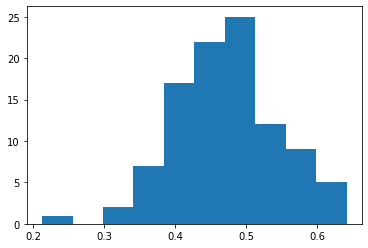

In [13]:
total_pearson = defaultdict(float)
print("Calculating pearson's for", NN, "neurons")
for i, n in enumerate(range(NN)):
    r, p = pearsonr(y_pred_total[:,n], y_test_total[:,n])
    total_pearson[n] = r

len(total_pearson)
values = total_pearson.values()

plt.figure()
plt.hist(values)
print("mean:", mean(values))
